In [1]:
#Bowel Movement Frequency
#Cohort Analysis
#James P. Johnson
#Credit to Christian Diener, PhD as noted
#v3-7-23

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

# Get the library
from arivale_data_interface import *
import arivale_data_interface as adi

# Set display options
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)
from IPython.display import display

# Apply these settings so the library knows where the data is
adi.apply_isb_config()

# If you want plots to show up in the notebook you need to run this
%matplotlib inline
plt.rcParams["figure.figsize"] = [10, 10]

In [5]:
#Obtain Bowel Movement Frequency (BMF) data:
bowel = adi.get_snapshot('assessments')
bowel = bowel.sort_values('days_in_program',ascending=True) # Sort df by days first
bowel = bowel.drop(columns = ['vendor','days_in_program','days_since_first_call','days_since_first_draw']) # Drop days and vendor, unneeded from this point
bowel = bowel.drop_duplicates(subset='public_client_id') # Keep only the first timepoint for each public_client_id
bowel = bowel.fillna(0) # Fill in empty BMF data with zero
bowel = bowel.set_index('public_client_id') # Arrange df by index of PCI
bowel = bowel[['assessment:digestion:bowel-movements:enum']]
bowel = bowel.rename(columns={"assessment:digestion:bowel-movements:enum":"bowel"}) # rename column to "bowel"
bowel = bowel[bowel['bowel'] != 0] #remove participants with no bowel data, reduce from 5764 -> 3955 individuals
bowel_list = ['(1) 2 or fewer times per week', '(2) 3-6 times per week', '(3) 1-3 times daily', '(4) 4+ times daily']
bowel_r = [1,2,3,4] #convert bowel responses to ordinal bowel movement frequency categories
bowel.bowel = bowel.bowel.replace(to_replace = bowel_list, value = bowel_r)
bowel = bowel.reset_index()
# 3955 individuals
bowel

/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_interface/snapshots_interface.py:101: FutureWarning: The default value of regex will change from True to False in a future version.
  t = pandas.to_datetime(x.str.replace("^arivale_snapshot.*(\\d{4}-\\d{2}-\\d{2}_\\d{4})$", "\\1"), format="%Y-%m-%d_%H%M")
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_interface/snapshots_interface.py:202: FutureWarning: The default value of regex will change from True to False in a future version.
  colnames = hdr.loc[~hdr.str.contains("^#")].head(1).str.replace("\n$","")
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_interface/snapshots_interface.py:207: FutureWarning: The default value of regex will change from True to False in a future version.
  hdr = hdr.loc[hdr.str.contains("^#")].str.replace("\n$","")
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_in

,public_client_id,bowel
0,01092042,3
1,01568974,3
2,01684342,2
3,01601230,3
4,01124029,3
...,...,...
3950,01395286,3
3951,01232614,3
3952,01181682,3
3953,01380110,3


In [6]:
#Obtain "eGFR" calculated GFR data (credit: Alexandra Ralevski) code chunk below:
################################################################################################
chems = adi.get_snapshot('chemistries', clean=True)
cl = adi.get_snapshot('clients', clean=True)
chems_dems = join_clients(cl, chems)
#these are the relevant column names
[col for col in chems.columns if 'CREAT' in col]
[col for col in chems.columns if 'GFR' in col]
def f(sex, age, creatinine): 
    if sex == 'F':
        if (creatinine/0.7) <=1:
            return 142*(((creatinine/0.7)**-0.241) * (0.9938**age) * 1.012)
        else:
            return 142*(((creatinine/0.7)**-1.200) * (0.9938**age) * 1.012)
    if sex == 'M':
        if (creatinine/0.9) <=1:
            return 142*(((creatinine/0.9)**-0.302) * (0.9938**age))
        else:
            return 142*(((creatinine/0.7)**-1.200) * (0.9938**age))

creat_calc = chems_dems[['public_client_id','sex', 'age', 'CREATININE_ENZ__SER']]

creat_calc['eGFR'] = creat_calc.apply(lambda x: f(x.sex, x.age, x.CREATININE_ENZ__SER), axis=1)
creat_calc.to_csv('eGFR.csv',index = False)
################################################################################################

#prepare eGFR dataframe:
eGFR = creat_calc
eGFR = eGFR.set_index('public_client_id')
eGFR = eGFR[['eGFR']] #select relevant columns
#drop duplicate entries to reduce 12316 entries across all individuals
#to 6133 individuals
eGFR = eGFR.reset_index().drop_duplicates('public_client_id')
eGFR

/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_interface/snapshots_interface.py:101: FutureWarning: The default value of regex will change from True to False in a future version.
  t = pandas.to_datetime(x.str.replace("^arivale_snapshot.*(\\d{4}-\\d{2}-\\d{2}_\\d{4})$", "\\1"), format="%Y-%m-%d_%H%M")
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_interface/snapshots_interface.py:202: FutureWarning: The default value of regex will change from True to False in a future version.
  colnames = hdr.loc[~hdr.str.contains("^#")].head(1).str.replace("\n$","")
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_interface/snapshots_interface.py:207: FutureWarning: The default value of regex will change from True to False in a future version.
  hdr = hdr.loc[hdr.str.contains("^#")].str.replace("\n$","")
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_in

,public_client_id,eGFR
0,01000552,NaN
1,01000978,NaN
2,01001181,NaN
3,01001298,99.024207
4,01001467,100.959522
...,...,...
12307,QIRL,111.687296
12311,ZU273983,118.179626
12312,ZU612255,70.256126
12313,ZU621944,120.472213


In [7]:
#Now, get the Assessments data
bio=adi.get_snapshot('clients')
a = bio['sex']
b = bio['age']
c = bio['public_client_id']
biodf = pd.DataFrame({'sex':a, 'age':b, 'public_client_id':c})
biodf = biodf[['sex','age','public_client_id']]
#biodf = biodf.set_index('public_client_id')
biodf #6133 individuals

#Get BMI data
bmi = adi.get_snapshot('weight_monthly')
bmi = bmi[['public_client_id','days_in_program','BMI_CALC']]
bmi = bmi.sort_values('days_in_program',ascending=True)
bmi = bmi.sort_values('public_client_id',ascending=True)
bmi = bmi.drop('days_in_program', axis=1)
bmi = bmi.drop_duplicates('public_client_id')
#bmi = bmi.set_index('public_client_id')
bmi = bmi.dropna()
bmi #5567 individuals


output_df = pd.merge(biodf,bmi)
output_df = pd.merge(output_df,bowel)
output_df = pd.merge(output_df,eGFR)
output_df = output_df.set_index('public_client_id')
output_df.to_csv('cohort.csv')
output_df

/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_interface/snapshots_interface.py:101: FutureWarning: The default value of regex will change from True to False in a future version.
  t = pandas.to_datetime(x.str.replace("^arivale_snapshot.*(\\d{4}-\\d{2}-\\d{2}_\\d{4})$", "\\1"), format="%Y-%m-%d_%H%M")
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_interface/snapshots_interface.py:202: FutureWarning: The default value of regex will change from True to False in a future version.
  colnames = hdr.loc[~hdr.str.contains("^#")].head(1).str.replace("\n$","")
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_interface/snapshots_interface.py:207: FutureWarning: The default value of regex will change from True to False in a future version.
  hdr = hdr.loc[hdr.str.contains("^#")].str.replace("\n$","")
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_in

,sex,age,BMI_CALC,bowel,eGFR
public_client_id,,,,,
01000552,M,54.0,31.619378,3,NaN
01001298,F,61.0,25.948604,3,99.024207
01001548,M,49.0,36.119222,3,105.411124
01001621,F,54.0,23.627456,2,69.439409
01001661,F,30.0,21.031478,3,120.947576
...,...,...,...,...,...
HX997448,F,50.0,30.381377,3,NaN
ZU273983,F,32.0,32.042139,2,118.179626
ZU612255,F,35.0,36.045023,2,70.256126


In [8]:
#BMI Mean and SD
bmi.mean()

/tmp/ipykernel_1035363/2747185137.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  bmi.mean()


BMI_CALC    27.158575
dtype: float64

In [9]:
np.std(bmi)

/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3613: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


BMI_CALC    5.877479
dtype: float64

In [10]:
#Get Community PTR from Arivale subset that Christian Diener, PhD provided:
metagenomic = pd.read_csv('Christian_metagenomic_Arivale_data.csv')
metagenomic = metagenomic[['public_client_id','log2_ptr','species_name']]

metagenomic['replicate_means'] = np.nan
metagenomic['overall_means'] = np.nan

for label,row in metagenomic.iterrows():
    metagenomic['replicate_means'][label] = metagenomic[(metagenomic['public_client_id'] == row['public_client_id']) & (metagenomic['species_name']==row['species_name'])]['log2_ptr'].mean()
metagenomic = metagenomic.drop_duplicates(subset = ['public_client_id','species_name'])
for label,row in metagenomic.iterrows():
    metagenomic['overall_means'][label] = metagenomic[metagenomic['public_client_id'] == metagenomic['public_client_id'][label]]['replicate_means'].mean()
metagenomic = metagenomic[['public_client_id','species_name','replicate_means','overall_means']]

metagenomic = metagenomic.sort_values(by = 'public_client_id')
metagenomic['public_client_id'] = metagenomic['public_client_id'].apply(lambda x: '{0:0>8}'.format(x))
metagenomic = metagenomic.set_index('public_client_id')

/tmp/ipykernel_1035363/4114446596.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metagenomic['replicate_means'][label] = metagenomic[(metagenomic['public_client_id'] == row['public_client_id']) & (metagenomic['species_name']==row['species_name'])]['log2_ptr'].mean()
/tmp/ipykernel_1035363/4114446596.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metagenomic['overall_means'][label] = metagenomic[metagenomic['public_client_id'] == metagenomic['public_client_id'][label]]['replicate_means'].mean()


In [11]:
metagenomic_bowel = pd.merge(bowel.set_index('public_client_id'), metagenomic, left_index = True, right_index = True)

#Get BMI data
bmi = adi.get_snapshot('weight_monthly')
bmi = bmi[['public_client_id','days_in_program','BMI_CALC']]
bmi = bmi.sort_values('days_in_program',ascending=True)
bmi = bmi.sort_values('public_client_id',ascending=True)
bmi = bmi.drop('days_in_program', axis=1)
bmi = bmi.drop_duplicates('public_client_id')
bmi = bmi.set_index('public_client_id')
bmi = bmi.dropna()
bmi #5567 individuals

#Now, get the Assessments data
bio=adi.get_snapshot('clients')
a = bio['sex']
b = bio['age']
c = bio['public_client_id']
biodf = pd.DataFrame({'sex':a, 'age':b, 'public_client_id':c})
biodf = biodf[['sex','age','public_client_id']]
biodf = biodf.set_index('public_client_id')
biodf #6133 individuals

#Create dataframe for R that can be used for PTR analysis
df = pd.merge(bowel.set_index('public_client_id'), metagenomic, left_index = True, right_index = True)
df = pd.merge(df, biodf,left_index = True, right_index = True)
df = pd.merge(df,eGFR.set_index('public_client_id'), left_index = True, right_index = True)
df = pd.merge(df,bmi, left_index = True, right_index = True)
df = df.reset_index()
df.to_csv('ptr_plot.csv')
df

/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_interface/snapshots_interface.py:101: FutureWarning: The default value of regex will change from True to False in a future version.
  t = pandas.to_datetime(x.str.replace("^arivale_snapshot.*(\\d{4}-\\d{2}-\\d{2}_\\d{4})$", "\\1"), format="%Y-%m-%d_%H%M")
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_interface/snapshots_interface.py:202: FutureWarning: The default value of regex will change from True to False in a future version.
  colnames = hdr.loc[~hdr.str.contains("^#")].head(1).str.replace("\n$","")
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_interface/snapshots_interface.py:207: FutureWarning: The default value of regex will change from True to False in a future version.
  hdr = hdr.loc[hdr.str.contains("^#")].str.replace("\n$","")
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/arivale_data_in

,public_client_id,bowel,species_name,replicate_means,overall_means,sex,age,eGFR,BMI_CALC
0,01009847,2,UBA1381 sp.,0.475302,0.721052,F,59.0,NaN,36.027836
1,01009847,2,Alistipes putredinis,0.239689,0.721052,F,59.0,NaN,36.027836
2,01009847,2,Fusicatenibacter saccharivorans,0.738998,0.721052,F,59.0,NaN,36.027836
3,01009847,2,Slackia HGM04378,0.503125,0.721052,F,59.0,NaN,36.027836
4,01009847,2,Bacteroides vulgatus,0.541283,0.721052,F,59.0,NaN,36.027836
...,...,...,...,...,...,...,...,...,...
1479,01944942,2,Alistipes putredinis,0.402085,0.706480,F,61.0,85.04965,25.410777
1480,01944942,2,Bacteroides thetaiotaomicron,0.682611,0.706480,F,61.0,85.04965,25.410777
1481,01944942,2,Dialister invisus,0.482711,0.706480,F,61.0,85.04965,25.410777
1482,01944942,2,Oscillospiraceae sp.,0.734456,0.706480,F,61.0,85.04965,25.410777


In [12]:
# get ANOVA table of GFR regressed against BMF with sex, age, BMI as covariates
# to see the effect of changes in GFR driven by BMF
# Ordinary Least Squares (OLS) model

#OLS regression to predict and assess GFR ~ BMF + sex + age + BMI
df = output_df.dropna()
sex = df[['sex']]
age = df[['age']]
bmi = df[['BMI_CALC']]
X = df[['bowel']]
Y = df[['eGFR']]
lr = smf.ols('Y ~ X + sex + age + bmi', df).fit() # create fit

df['eGFR_pred'] = lr.fittedvalues
df['residuals'] = lr.resid

#melt df for plotting
df_melt = pd.melt(df.reset_index(), id_vars=['public_client_id','bowel','sex','age','BMI_CALC'], value_vars=None, var_name='GFR', value_name='value', col_level=None, ignore_index=True)
df_melt

model = smf.ols('value ~ C(bowel) + sex + age + BMI_CALC', data = df_melt).fit() # create fit
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table
# output (ANOVA F and p value)
# C(bowel) or "BMF" is insignificantly associated with driving GFR when accounting for age, sex, and BMI

/tmp/ipykernel_1035363/1817661382.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['eGFR_pred'] = lr.fittedvalues
/tmp/ipykernel_1035363/1817661382.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['residuals'] = lr.resid


,sum_sq,df,F,PR(>F)
C(bowel),1.700967e+03,3.0,0.282938,8.377580e-01
sex,3.361188e+05,1.0,167.729271,4.388654e-38
age,2.979086e+05,1.0,148.661708,5.621044e-34
BMI_CALC,3.381995e+02,1.0,0.168768,6.812174e-01
Residual,2.212145e+07,11039.0,NaN,NaN


/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/users/jajohnso/miniconda3/envs/arivale-py/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='bowel', ylabel='value'>

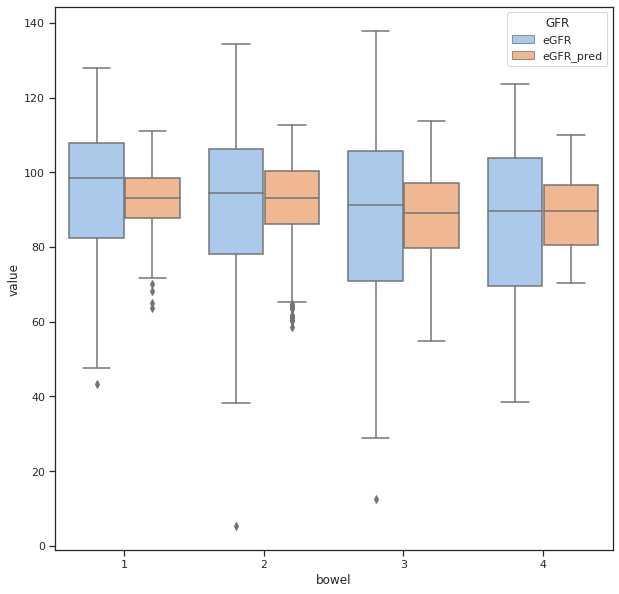

In [13]:
#plot GFR from Arivale blood chemistry labs, eGFR calculated, and eGFR predicted in boxplots
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(data = df_melt[df_melt['GFR'].isin(['GFR, MDRD','eGFR','eGFR_pred'])], x = 'bowel', dodge = True, y = 'value', hue = 'GFR')